# NOTEBOOK 04 : MODÉLISATION
**Projet** : REG09 - Prévision des ventes (item_nbr)

**Objectif** : Entraîner modèles ML (focus LightGBM)

**Données** : Features créées par notebook 03

In [ ]:
#!pip install lightgbm xgboost mlflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 484.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 595.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 347.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 492.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 548.7 kB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 683.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 563.3 kB/s eta 0:00:00a 0:00:01
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from datetime import datetime

# MLflow
import mlflow
import mlflow.lightgbm
import mlflow.xgboost
import mlflow.sklearn

# ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

/usr/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. CHARGEMENT DES DONNÉES

In [3]:
# Configuration MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("favorita-sales-forecasting")

print("✓ MLflow configuré")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"  Experiment: favorita-sales-forecasting")
print(f"\n💡 Pour voir l'interface MLflow, lancez: mlflow ui")

✓ MLflow configuré
  Tracking URI: file:./mlruns
  Experiment: favorita-sales-forecasting

💡 Pour voir l'interface MLflow, lancez: mlflow ui


In [4]:
print("Chargement des données avec features...")

# Charger X et y
X = pd.read_csv('data/processed/X_train.csv')
y = pd.read_csv('data/processed/y_train.csv', header=0, names=['unit_sales'])['unit_sales']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nMémoire X: {X.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nFeatures disponibles: {X.columns.tolist()}")

Chargement des données avec features...
X shape: (6980883, 35)
y shape: (6980883,)

Mémoire X: 1864.1 MB

Features disponibles: ['store_nbr', 'item_nbr', 'onpromotion', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_weekend', 'is_month_start', 'is_month_end', 'is_payday', 'dcoilwtico', 'is_holiday', 'transactions', 'store_nbr_freq', 'item_nbr_freq', 'city_encoded', 'state_encoded', 'type_encoded', 'family_encoded', 'class_encoded', 'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7', 'is_return', 'unit_sales_abs', 'perishable', 'cluster']


In [5]:
# Vérifier NaN
missing = X.isnull().sum()
missing = missing[missing > 0]

if len(missing) > 0:
    print(f"ATTENTION: {len(missing)} colonnes avec NaN")
    print(missing)
    print("\nRemplissage avec médiane...")
    for col in missing.index:
        X[col].fillna(X[col].median(), inplace=True)
else:
    print("Aucune valeur manquante")

print(f"\nStatistiques y:")
print(y.describe())

Aucune valeur manquante

Statistiques y:
count    6.980883e+06
mean     7.916429e+00
std      2.224768e+01
min     -3.451363e+03
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.153300e+04
Name: unit_sales, dtype: float64
count    6.980883e+06
mean     7.916429e+00
std      2.224768e+01
min     -3.451363e+03
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.153300e+04
Name: unit_sales, dtype: float64


## 2. TRAIN/VALIDATION SPLIT

In [6]:
# Split temporel (80/20)
# Pour séries temporelles, pas de shuffle
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_val = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_val = y.iloc[split_idx:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"\nRatio: {len(X_train)/len(X)*100:.1f}% train / {len(X_val)/len(X)*100:.1f}% val")

Train: (5584706, 35), (5584706,)
Val:   (1396177, 35), (1396177,)

Ratio: 80.0% train / 20.0% val


## 3. FONCTION D'ÉVALUATION

In [7]:
def evaluate_model(y_true, y_pred, model_name="Model", log_to_mlflow=False, prefix=""):
    """
    Évalue un modèle avec plusieurs métriques.
    
    Args:
        y_true: Valeurs réelles
        y_pred: Prédictions
        model_name: Nom du modèle (pour affichage)
        log_to_mlflow: Si True, log les métriques dans MLflow
        prefix: Préfixe pour les noms de métriques MLflow (ex: "train_", "val_")
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # NWRMSLE (Normalized Weighted Root Mean Squared Logarithmic Error)
    # Métrique Kaggle pour ce dataset
    weights = np.ones_like(y_true)
    # Perishable items ont poids 1.25 (si disponible)
    
    log_errors = (np.log1p(np.maximum(0, y_pred)) - np.log1p(np.maximum(0, y_true))) ** 2
    nwrmsle = np.sqrt(np.sum(weights * log_errors) / np.sum(weights))
    
    print("=" * 60)
    print(f"ÉVALUATION: {model_name}")
    print("=" * 60)
    print(f"MSE     : {mse:.4f}")
    print(f"RMSE    : {rmse:.4f}")
    print(f"MAE     : {mae:.4f}")
    print(f"R2      : {r2:.4f}")
    print(f"NWRMSLE : {nwrmsle:.4f} (métrique Kaggle)")
    print("=" * 60)
    
    # Logger dans MLflow si demandé
    if log_to_mlflow:
        mlflow.log_metric(f"{prefix}mse", mse)
        mlflow.log_metric(f"{prefix}rmse", rmse)
        mlflow.log_metric(f"{prefix}mae", mae)
        mlflow.log_metric(f"{prefix}r2", r2)
        mlflow.log_metric(f"{prefix}nwrmsle", nwrmsle)
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'nwrmsle': nwrmsle}

## 4. LIGHTGBM (MODÈLE PRINCIPAL)

In [8]:
print("=" * 70)
print("ENTRAÎNEMENT LIGHTGBM")
print("=" * 70)

# Démarrer une run MLflow
with mlflow.start_run(run_name="LightGBM-baseline") as run:
    lgb_run_id = run.info.run_id  # Sauvegarder pour réutiliser dans les cellules suivantes
    
    # Paramètres optimisés pour régression
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1,
        'random_state': 42
    }
    
    # Logger les paramètres dans MLflow
    mlflow.log_params(lgb_params)
    mlflow.log_param("num_boost_round", 1000)
    mlflow.log_param("early_stopping_rounds", 50)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    mlflow.log_param("n_features", X_train.shape[1])
    
    # Créer datasets LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    print("Entraînement en cours...")
    lgb_model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
    )
    
    # Logger le nombre d'itérations
    mlflow.log_metric("best_iteration", lgb_model.best_iteration)
    
    # Logger le modèle LightGBM
    mlflow.lightgbm.log_model(lgb_model, "model")
    
    print(f"\n✓ Entraînement terminé")
    print(f"✓ Run ID: {lgb_run_id}")

ENTRAÎNEMENT LIGHTGBM
Entraînement en cours...
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 6.53048	valid's rmse: 15.9089
[100]	train's rmse: 5.57478	valid's rmse: 15.11
[150]	train's rmse: 5.04312	valid's rmse: 14.6096
[200]	train's rmse: 4.6207	valid's rmse: 14.5049


2026/02/15 00:45:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Early stopping, best iteration is:
[180]	train's rmse: 4.76691	valid's rmse: 14.2626

✓ Entraînement terminé
✓ Run ID: f59a3f4098094ab7beb85d685a9bd9d6


In [9]:
# Continuer la run MLflow pour logger les métriques
with mlflow.start_run(run_id=lgb_run_id):
    
    # Prédictions
    y_pred_train_lgb = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
    y_pred_val_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    
    # Évaluation train
    print("\nPERFORMANCE TRAIN:")
    metrics_train_lgb = evaluate_model(y_train, y_pred_train_lgb, "LightGBM Train", 
                                       log_to_mlflow=True, prefix="train_")
    
    # Évaluation validation
    print("\nPERFORMANCE VALIDATION:")
    metrics_val_lgb = evaluate_model(y_val, y_pred_val_lgb, "LightGBM Validation",
                                     log_to_mlflow=True, prefix="val_")
    
    # Logger des tags supplémentaires
    mlflow.set_tag("model_type", "LightGBM")
    mlflow.set_tag("dataset", "hybrid_20pct_365d")
    
    print(f"\n✓ Métriques loggées dans MLflow (Run ID: {lgb_run_id})")


PERFORMANCE TRAIN:
ÉVALUATION: LightGBM Train
MSE     : 22.7235
RMSE    : 4.7669
MAE     : 0.1141
R2      : 0.9425
NWRMSLE : 0.0320 (métrique Kaggle)

PERFORMANCE VALIDATION:
ÉVALUATION: LightGBM Validation
MSE     : 203.4230
RMSE    : 14.2626
MAE     : 0.2616
R2      : 0.7724
NWRMSLE : 0.0561 (métrique Kaggle)

✓ Métriques loggées dans MLflow (Run ID: f59a3f4098094ab7beb85d685a9bd9d6)



TOP 20 FEATURES IMPORTANTES:
                 feature    importance
32        unit_sales_abs  1.387752e+10
30  sales_rolling_mean_7  1.878327e+09
27         class_encoded  2.689621e+08
1               item_nbr  2.557880e+08
20          transactions  2.192303e+08
23          city_encoded  1.767101e+08
28           sales_lag_7  1.500567e+08
29          sales_lag_14  1.436325e+08
22         item_nbr_freq  1.314055e+08
5                    day  1.281578e+08
18            dcoilwtico  6.715819e+07
7              dayofyear  6.441063e+07
24         state_encoded  6.136386e+07
4                  month  4.715961e+07
0              store_nbr  3.849274e+07
6              dayofweek  3.558977e+07
26        family_encoded  2.554695e+07
2            onpromotion  2.242571e+07
12         dayofweek_sin  1.826014e+07
11             month_cos  1.823000e+07


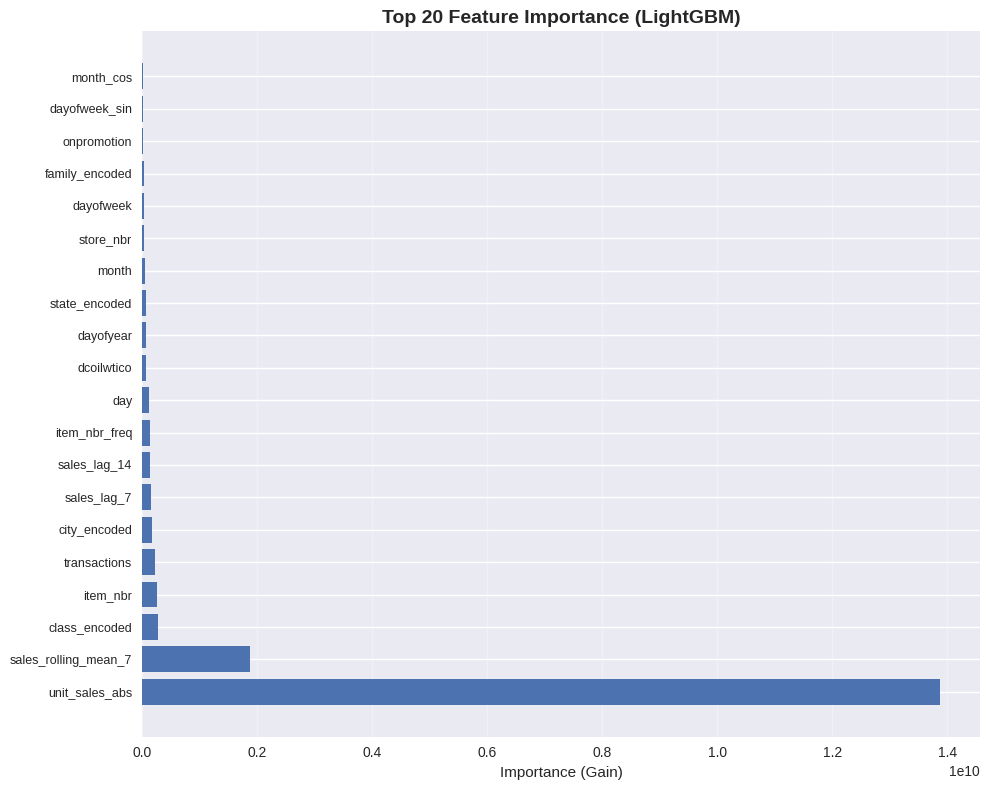


✓ Feature importance loggée dans MLflow


In [14]:
# Continuer la run MLflow
with mlflow.start_run(run_id=lgb_run_id):
    
    # Feature importance
    importance = lgb_model.feature_importance(importance_type='gain')
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print("\nTOP 20 FEATURES IMPORTANTES:")
    print(importance_df.head(20))
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(10, 8))
    top20 = importance_df.head(20)
    ax.barh(range(len(top20)), top20['importance'].values)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['feature'].values, fontsize=9)
    ax.set_title('Top 20 Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance (Gain)')
    ax.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    
    # Sauvegarder et logger dans MLflow
    plt.savefig('outputs/04_lgb_feature_importance.png', dpi=300, bbox_inches='tight')
    mlflow.log_artifact('outputs/04_lgb_feature_importance.png')
    
    plt.show()
    
    # Logger les top features comme métriques
    for i, row in importance_df.head(5).iterrows():
        mlflow.log_metric(f"importance_{row['feature']}", row['importance'])
    
    print(f"\n✓ Feature importance loggée dans MLflow")

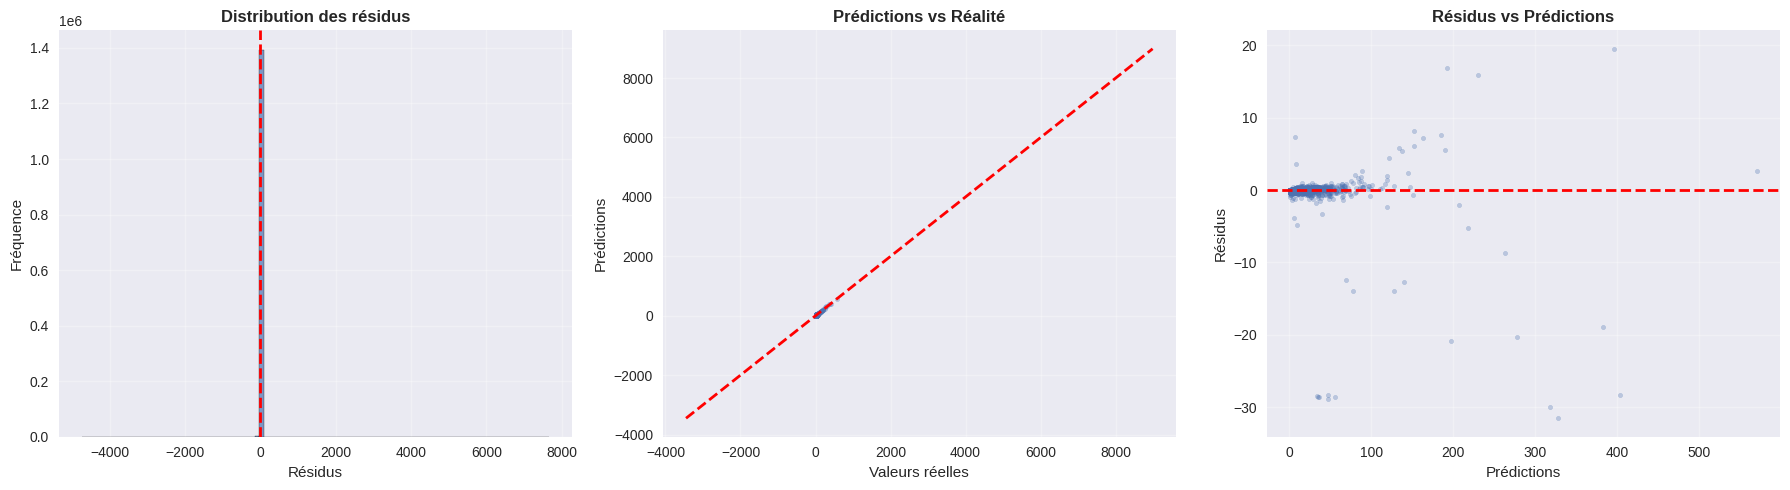


✓ Analyse des résidus loggée dans MLflow


In [15]:
# Continuer la run MLflow
with mlflow.start_run(run_id=lgb_run_id):
    
    # Analyse des résidus
    residuals = y_val - y_pred_val_lgb
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Distribution résidus
    axes[0].hist(residuals, bins=100, edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribution des résidus', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Résidus')
    axes[0].set_ylabel('Fréquence')
    axes[0].axvline(0, color='r', linestyle='--', linewidth=2)
    axes[0].grid(alpha=0.3)
    
    # Predicted vs Actual
    sample_size = min(5000, len(y_val))
    sample_idx = np.random.choice(len(y_val), sample_size, replace=False)
    axes[1].scatter(y_val.iloc[sample_idx], y_pred_val_lgb[sample_idx], alpha=0.3, s=10)
    axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
    axes[1].set_title('Prédictions vs Réalité', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Valeurs réelles')
    axes[1].set_ylabel('Prédictions')
    axes[1].grid(alpha=0.3)
    
    # Residuals vs Predicted
    axes[2].scatter(y_pred_val_lgb[sample_idx], residuals.iloc[sample_idx], alpha=0.3, s=10)
    axes[2].axhline(0, color='r', linestyle='--', linewidth=2)
    axes[2].set_title('Résidus vs Prédictions', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Prédictions')
    axes[2].set_ylabel('Résidus')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Sauvegarder et logger dans MLflow
    plt.savefig('outputs/04_lgb_residuals.png', dpi=300, bbox_inches='tight')
    mlflow.log_artifact('outputs/04_lgb_residuals.png')
    
    plt.show()
    
    # Logger quelques stats des résidus
    mlflow.log_metric("residuals_mean", residuals.mean())
    mlflow.log_metric("residuals_std", residuals.std())
    
    print(f"\n✓ Analyse des résidus loggée dans MLflow")

## 5. MODÈLES COMPLÉMENTAIRES

In [11]:
# XGBoost
print("=" * 70)
print("ENTRAÎNEMENT XGBOOST")
print("=" * 70)

# Démarrer une nouvelle run MLflow pour XGBoost
with mlflow.start_run(run_name="XGBoost-baseline") as run:
    xgb_run_id = run.info.run_id
    
    xgb_params = {
        'objective': 'reg:squarederror',
        'max_depth': 6,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'n_estimators': 500,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'early_stopping_rounds': 50
    }
    
    # Logger les paramètres
    mlflow.log_params(xgb_params)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    mlflow.log_param("n_features", X_train.shape[1])
    
    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=50
    )
    
    # Logger le modèle
    mlflow.xgboost.log_model(xgb_model, "model")
    
    # Logger best_iteration seulement s'il existe
    if hasattr(xgb_model, 'best_iteration') and xgb_model.best_iteration is not None:
        mlflow.log_metric("best_iteration", xgb_model.best_iteration)
    
    # Prédictions et évaluation
    y_pred_val_xgb = xgb_model.predict(X_val)
    metrics_val_xgb = evaluate_model(y_val, y_pred_val_xgb, "XGBoost Validation",
                                     log_to_mlflow=True, prefix="val_")
    
    # Tags
    mlflow.set_tag("model_type", "XGBoost")
    mlflow.set_tag("dataset", "hybrid_20pct_365d")
    
    print(f"\n✓ XGBoost loggé dans MLflow (Run ID: {xgb_run_id})")

ENTRAÎNEMENT XGBOOST
[0]	validation_0-rmse:29.26007
[50]	validation_0-rmse:23.00053
[86]	validation_0-rmse:23.34466


2026/02/15 00:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


ÉVALUATION: XGBoost Validation
MSE     : 526.9258
RMSE    : 22.9549
MAE     : 1.5367
R2      : 0.4106
NWRMSLE : 0.2335 (métrique Kaggle)

✓ XGBoost loggé dans MLflow (Run ID: e854a1a19c68414c973952b5571a2973)


In [12]:
# Random Forest (baseline simple)
# ATTENTION: peut être lent sur gros datasets
TRAIN_RF = False  # Mettre à True pour entraîner RF

if TRAIN_RF:
    print("=" * 70)
    print("ENTRAÎNEMENT RANDOM FOREST (optionnel)")
    print("=" * 70)
    
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    rf_model.fit(X_train, y_train)
    y_pred_val_rf = rf_model.predict(X_val)
    metrics_val_rf = evaluate_model(y_val, y_pred_val_rf, "Random Forest Validation")
else:
    print("Random Forest ignoré (TRAIN_RF=False)")

Random Forest ignoré (TRAIN_RF=False)


## 6. COMPARAISON DES MODÈLES

In [13]:
# Comparer performances
results = pd.DataFrame({
    'Model': ['LightGBM'],
    'RMSE': [metrics_val_lgb['rmse']],
    'MAE': [metrics_val_lgb['mae']],
    'R2': [metrics_val_lgb['r2']],
    'NWRMSLE': [metrics_val_lgb['nwrmsle']]
})

if 'metrics_val_xgb' in locals():
    results = pd.concat([results, pd.DataFrame({
        'Model': ['XGBoost'],
        'RMSE': [metrics_val_xgb['rmse']],
        'MAE': [metrics_val_xgb['mae']],
        'R2': [metrics_val_xgb['r2']],
        'NWRMSLE': [metrics_val_xgb['nwrmsle']]
    })], ignore_index=True)

if TRAIN_RF and 'metrics_val_rf' in locals():
    results = pd.concat([results, pd.DataFrame({
        'Model': ['RandomForest'],
        'RMSE': [metrics_val_rf['rmse']],
        'MAE': [metrics_val_rf['mae']],
        'R2': [metrics_val_rf['r2']],
        'NWRMSLE': [metrics_val_rf['nwrmsle']]
    })], ignore_index=True)

print("=" * 70)
print("COMPARAISON DES MODÈLES (Validation Set)")
print("=" * 70)
print(results.to_string(index=False))
print("\nMeilleur modèle (NWRMSLE): ", results.loc[results['NWRMSLE'].idxmin(), 'Model'])

COMPARAISON DES MODÈLES (Validation Set)
   Model      RMSE      MAE       R2  NWRMSLE
LightGBM 14.262642 0.261560 0.772445 0.056144
 XGBoost 22.954865 1.536657 0.410564 0.233542

Meilleur modèle (NWRMSLE):  LightGBM


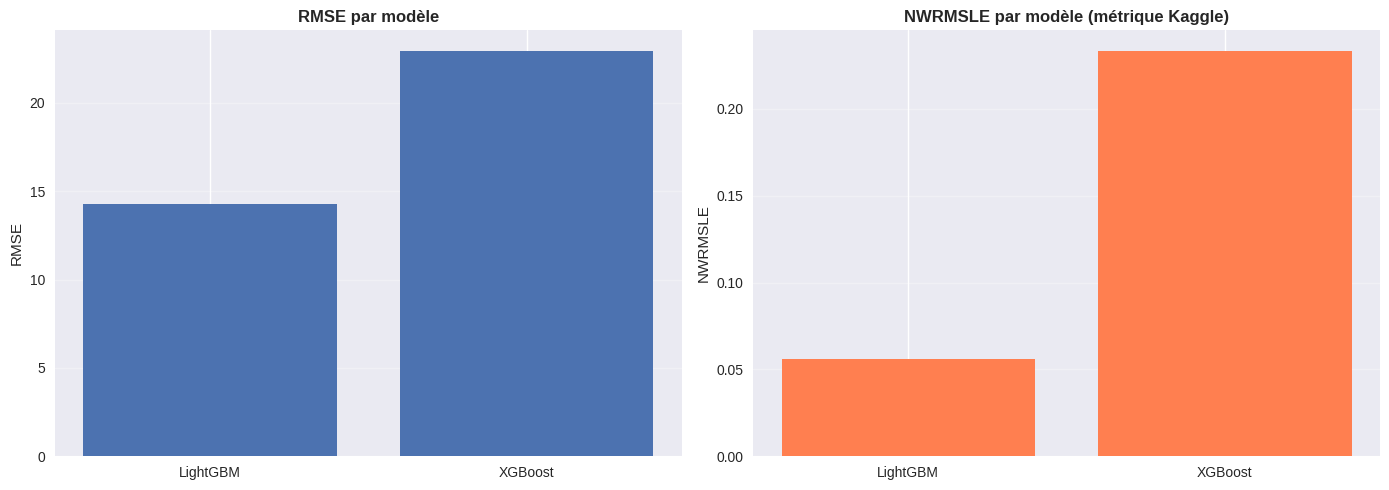

In [14]:
# Visualisation comparaison
if len(results) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # RMSE
    axes[0].bar(results['Model'], results['RMSE'])
    axes[0].set_title('RMSE par modèle', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('RMSE')
    axes[0].grid(alpha=0.3, axis='y')
    
    # NWRMSLE
    axes[1].bar(results['Model'], results['NWRMSLE'], color='coral')
    axes[1].set_title('NWRMSLE par modèle (métrique Kaggle)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('NWRMSLE')
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('outputs/04_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. SAUVEGARDE MODÈLE

In [ ]:
os.makedirs('models', exist_ok=True)

# Sauvegarder LightGBM
lgb_model.save_model('models/lgb_model.txt')
print("LightGBM sauvegardé: models/lgb_model.txt")

# Sauvegarder XGBoost si entraîné
if 'xgb_model' in locals():
    joblib.dump(xgb_model, 'models/xgb_model.pkl')
    print("XGBoost sauvegardé: models/xgb_model.pkl")

# Sauvegarder RF si entraîné
if TRAIN_RF and 'rf_model' in locals():
    joblib.dump(rf_model, 'models/rf_model.pkl')
    print("RandomForest sauvegardé: models/rf_model.pkl")

# Sauvegarder résultats
results.to_csv('outputs/04_model_results.csv', index=False)
print("Résultats sauvegardés: outputs/04_model_results.csv")


print("\n✓ Sauvegarde terminée")

LightGBM sauvegardé: models/lgb_model.txt
XGBoost sauvegardé: models/xgb_model.pkl
Résultats sauvegardés: outputs/04_model_results.csv

✓ Sauvegarde terminée


## 8. SYNTHÈSE FINALE

In [18]:
print("=" * 70)
print("SYNTHÈSE MODÉLISATION")
print("=" * 70)

print("\n1. DONNÉES")
print(f"   Total samples    : {len(X):,}")
print(f"   Train samples    : {len(X_train):,}")
print(f"   Val samples      : {len(X_val):,}")
print(f"   Nombre features  : {X.shape[1]}")

print("\n2. MODÈLES ENTRAÎNÉS")
print(f"   LightGBM         : OUI")
print(f"   XGBoost          : {'OUI' if 'xgb_model' in locals() else 'NON'}")
print(f"   Random Forest    : {'OUI' if TRAIN_RF and 'rf_model' in locals() else 'NON'}")

print("\n3. PERFORMANCE LIGHTGBM (modèle principal)")
print(f"   RMSE             : {metrics_val_lgb['rmse']:.4f}")
print(f"   MAE              : {metrics_val_lgb['mae']:.4f}")
print(f"   R2               : {metrics_val_lgb['r2']:.4f}")
print(f"   NWRMSLE (Kaggle) : {metrics_val_lgb['nwrmsle']:.4f}")



print("\n5. FICHIERS SAUVEGARDÉS")
print("   - models/lgb_model.txt")
if 'xgb_model' in locals():
    print("   - models/xgb_model.pkl")
print("   - outputs/04_model_results.csv")
print("   - outputs/04_feature_importance.csv")
print("   - outputs/04_lgb_feature_importance.png")
print("   - outputs/04_lgb_residuals.png")

print("\n" + "=" * 70)
print("MODÉLISATION TERMINÉE")
print("=" * 70)

SYNTHÈSE MODÉLISATION

1. DONNÉES
   Total samples    : 6,980,883
   Train samples    : 5,584,706
   Val samples      : 1,396,177
   Nombre features  : 35

2. MODÈLES ENTRAÎNÉS
   LightGBM         : OUI
   XGBoost          : OUI
   Random Forest    : NON

3. PERFORMANCE LIGHTGBM (modèle principal)
   RMSE             : 14.2626
   MAE              : 0.2616
   R2               : 0.7724
   NWRMSLE (Kaggle) : 0.0561

5. FICHIERS SAUVEGARDÉS
   - models/lgb_model.txt
   - models/xgb_model.pkl
   - outputs/04_model_results.csv
   - outputs/04_feature_importance.csv
   - outputs/04_lgb_feature_importance.png
   - outputs/04_lgb_residuals.png

MODÉLISATION TERMINÉE


## MLFLOW UI

Pour visualiser vos expériences dans l'interface MLflow :

```bash
mlflow ui
```

Puis ouvrez : **http://localhost:5000**

### Ce que vous pouvez faire dans MLflow UI :

1. **Comparer les runs** : Voir tous vos entraînements côte à côte
2. **Visualiser les métriques** : Courbes d'évolution, comparaisons
3. **Explorer les paramètres** : Voir quels hyperparamètres ont été utilisés
4. **Télécharger les modèles** : Récupérer les modèles sauvegardés
5. **Voir les artifacts** : Graphiques, feature importance, etc.

### Tips MLflow :

- **Rechercher des runs** : Utilisez le filtre pour trouver les meilleurs modèles
  ```
  metrics.val_nwrmsle < 0.5
  ```

- **Comparer plusieurs runs** : Sélectionnez-les et cliquez sur "Compare"

- **Charger un modèle** :
  ```python
  logged_model = 'runs:/<run_id>/model'
  loaded_model = mlflow.lightgbm.load_model(logged_model)
  ```